### Pytorch Lightning Training

In [3]:
import torch
import cv2
import numpy as np

In [2]:

import pytorch_lightning as pl
from models.densenetccnl import Backwardmapper
DATA_PATH = 'Dataset Preview/Inv3D preview complete V2/data/'
data_dir= 'Dataset Preview/Inv3D preview complete V2/data/train/'


from custom_dataset import CustomImageDataset_wc
dataset_train = CustomImageDataset_wc(data_dir=DATA_PATH+'train/', transform=True)
dataset_val = CustomImageDataset_wc(data_dir=DATA_PATH+'val/', transform=True)
dataset_test = CustomImageDataset_wc(data_dir=DATA_PATH+'test/', transform=True)

from custom_dataset import Dataset_backward_mapping
train_dataset_bm = Dataset_backward_mapping(data_dir=DATA_PATH+'train/')



from torch.utils.data import DataLoader
train_loader_bm = DataLoader(train_dataset_bm, batch_size=1, num_workers=8, shuffle=True)

train_loader = DataLoader(dataset_train, batch_size= 1, num_workers=12)
val_loader = DataLoader(dataset_val, batch_size= 1, num_workers=12)
test_loader = DataLoader(dataset_test, batch_size= 1, num_workers=12)

from models import unetnc
model = unetnc.Estimator3d(input_nc=3, output_nc=3, num_downs=0)
model_bm = Backwardmapper()

#8 channel


# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(gpus=8) (if you have GPUs)
trainer = pl.Trainer(gpus=1, max_epochs = 200)
#trainer = pl.Trainer(auto_select_gpus = True, max_epochs = 100)
#trainer.fit(model, train_loader)

# Wie sieht der Batch aus, der vom trainer und train_loader generiert wird?

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [10]:
trainer.fit(model_bm, train_loader_bm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params
------------------------------------------------
0 | encoder | waspDenseEncoder128 | 21.9 M
1 | decoder | waspDenseDecoder128 | 23.8 M
------------------------------------------------
45.7 M    Trainable params
0         Non-trainable params
45.7 M    Total params
182.997   Total estimated model params size (MB)
Epoch 199: 100%|██████████| 7/7 [00:00<00:00,  8.36it/s, loss=0.0741, v_num=36]


In [25]:
CustomImageDataset_wc.calculate_min_and_max(data_dir)

(1.0874363,
 -1.0870038,
 0.87451214,
 -0.8838198,
 0.31209734,
 -0.30815947,
 0.014783481)

In [26]:
for batch in train_loader_bm:
    images, labels = batch


In [10]:
import torch.nn.functional as F
#@staticmethod
def unwarp_image(img, bm):
    assert bm.shape[3] == 2, "BM shape needs to be (N, H, W, C)"
    
    n, c, h, w = img.shape

    bm = bm.transpose(3, 2).transpose(2, 1)
    bm = F.interpolate(bm, size=(h, w), mode='bilinear', align_corners=True) # align_corners=True -> old behaviour
    bm = bm.transpose(1, 2).transpose(2, 3)

    img = img.float()
    res = F.grid_sample(input=img, grid=bm, align_corners=True) # align_corners=True -> old behaviour
    res = torch.clamp(res, 0, 1) # clip values because of numerical instabilities
    return res 

In [11]:
import numpy as np

data_path = 'Dataset Preview/Inv3D preview complete V2/data/train/08'

img = cv2.imread('Dataset Preview/Inv3D preview complete V2/data/train/08/warped_document.png')
#img = dataset_train.transform_img(img)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)#.transpose(2,3).transpose
img = img / 255
print(img.shape)

torch.Size([1, 3, 256, 256])


In [12]:
warped_bm = np.load(data_path + '/warped_BM.npz')['warped_BM']
warped_bm = torch.from_numpy(warped_bm).float()
warped_bm = warped_bm.unsqueeze(0)


In [13]:
unwarped_img = unwarp_image(img,warped_bm)
unwarped_img = torch.transpose(unwarped_img,1,2)
unwarped_img = torch.transpose(unwarped_img,2,3)

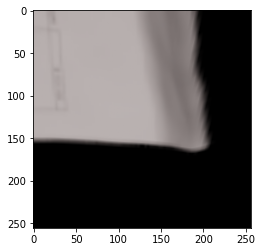

In [14]:
import matplotlib.pyplot as plt
plt.imshow(unwarped_img.numpy()[0])